In [1]:
import numpy as np 
import pandas as pd 
import pyodbc
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter('ignore')

In [2]:
servername = 'DESKTOP-G20KDR6\SQLEXPRESS'

In [3]:
dwh_conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER='+servername+';DATABASE=UnitedOutdoors; Trusted_Connection=yes')



In [4]:
# make a query to get the data from the database from order_details and make a join with customer we can use customer_sk as a key
query = 'SELECT * FROM dbo.order_details'
df = pd.read_sql(query, dwh_conn)
df = df[['order_details_sk', 'order_date', 'product_quantity', 'product_listprice', 'product_sk', 'employee_sk', 'customer_sk', ]]
df = df.dropna()


# make a new column where the total price is shown
df['total_price'] = df['product_quantity'] * df['product_listprice']

# remove the columns that are not needed
df = df.drop([ 'product_listprice', 'order_details_sk'], axis=1)

# datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract year, month, and day as separate features
df['order_month'] = df['order_date'].dt.month

# Drop the original order_date column
df.drop('order_date', axis=1, inplace=True)

# combine where product_sk and order_month are the same
df = df.groupby(['product_sk', 'order_month']).sum().reset_index()



df



,product_sk,order_month,product_quantity,employee_sk,customer_sk,total_price
0,212,1,179,15606.0,1063744,3672.3310
1,212,2,138,10732.0,729047,2751.0834
2,212,3,582,31551.0,2152469,11939.4130
3,212,4,198,12408.0,847494,3952.8529
4,212,5,579,29586.0,2011022,10268.5388
...,...,...,...,...,...,...
3295,591,8,504,4133.0,1876,7560.0000
3296,591,9,468,4753.0,2242,7020.0000
3297,591,10,540,4597.0,2009,8100.0000
3298,591,11,420,3927.0,1595,6300.0000


In [5]:
df.corr()['product_quantity']

product_sk         -0.106813
order_month        -0.049542
product_quantity    1.000000
employee_sk         0.691283
customer_sk         0.645399
total_price         0.151787
Name: product_quantity, dtype: float64

In [6]:
# Define the features and target
X = df[['product_sk', 'order_month', 'employee_sk', 'customer_sk', 'total_price']]
y = df['product_quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the product_quantity for the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

# Predict the quantity sold for each product for every month
df['predicted_quantity'] = model.predict(scaler.transform(X))

df

Mean Squared Error: 2836.105335813098
R2 Score: 0.7292612765444738


,product_sk,order_month,product_quantity,employee_sk,customer_sk,total_price,predicted_quantity
0,212,1,179,15606.0,1063744,3672.3310,200.573619
1,212,2,138,10732.0,729047,2751.0834,128.270102
2,212,3,582,31551.0,2152469,11939.4130,436.716805
3,212,4,198,12408.0,847494,3952.8529,148.784281
4,212,5,579,29586.0,2011022,10268.5388,411.413480
...,...,...,...,...,...,...,...
3295,591,8,504,4133.0,1876,7560.0000,311.516745
3296,591,9,468,4753.0,2242,7020.0000,350.837303
3297,591,10,540,4597.0,2009,8100.0000,339.937229
3298,591,11,420,3927.0,1595,6300.0000,296.417887


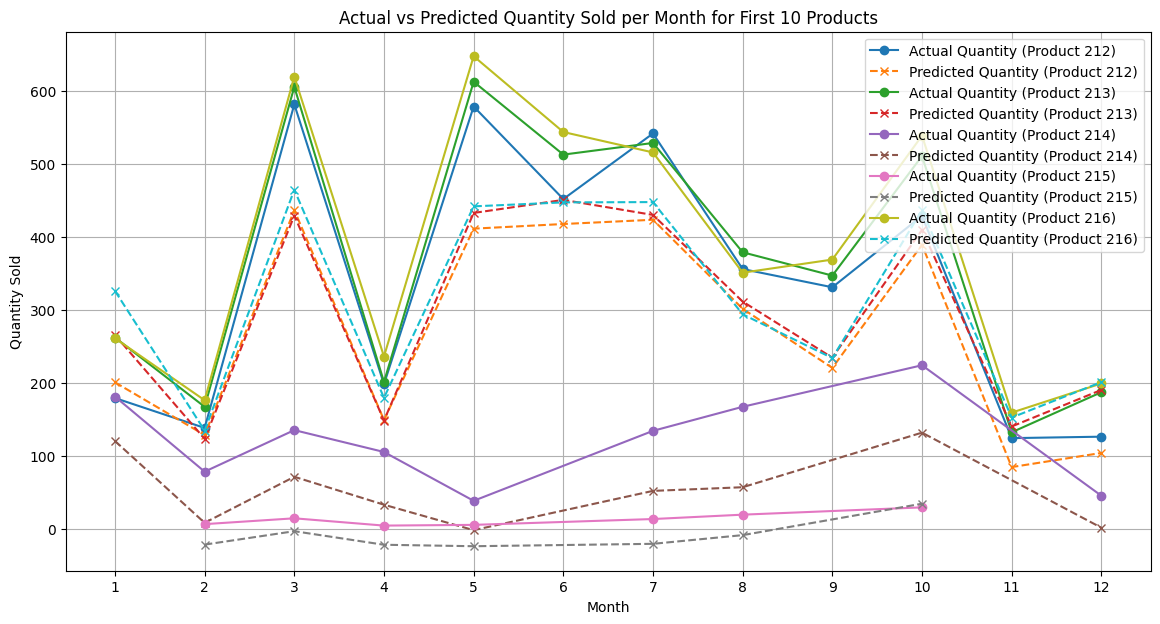

In [7]:
# Filter to the first 10 unique products
unique_products = df['product_sk'].unique()[:5]
df_filtered = df[df['product_sk'].isin(unique_products)]

# Plotting the actual vs predicted quantities
plt.figure(figsize=(14, 7))

# Group by product and month for plotting
for product in unique_products:
    product_data = df_filtered[df_filtered['product_sk'] == product]
    
    # Plot for actual quantities
    plt.plot(product_data['order_month'], product_data['product_quantity'], marker='o', linestyle='-', label=f'Actual Quantity (Product {product})')

    # Plot for predicted quantities
    plt.plot(product_data['order_month'], product_data['predicted_quantity'], marker='x', linestyle='--', label=f'Predicted Quantity (Product {product})')

plt.title('Actual vs Predicted Quantity Sold per Month for First 10 Products')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.xticks(range(1, 13))  # Assuming we want all months on the x-axis
plt.legend()
plt.grid(True)
plt.show()